In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
from scipy.optimize import fsolve, root
import csv
import pandas as pd
from IPython.display import Image
import progressbar

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def inch2m(inch):
    return inch * 0.0254

def m2inch(m):
    return m/0.0254

def loadcsvfile(filename, path='data/', delimiter=';'):
    exceldata = pd.read_excel(path+filename)
    exceldata.to_csv(path+'csv/'+filename[:-5]+'.csv', sep=delimiter, index=None, header=True)
    csvdata = pd.read_csv(path+'csv/'+filename[:-5]+'.csv', delimiter=delimiter)
    csvdata = csvdata.iloc[1:]
    csvdata.index -= 1
    for key in csvdata:
        if key != 'experiment':
            csvdata[key] = csvdata[key].astype('float')
    return csvdata

In [3]:
HaEl1 = loadcsvfile('Harleman_Elder_1.xlsx')
HaEl2 = loadcsvfile('Harleman_Elder_2.xlsx')
NL1204 = loadcsvfile('Noordland_M1204.xlsx')
IJ = loadcsvfile('IJmuiden.xlsx')
Yu = loadcsvfile('Yu.xlsx')

In [4]:
g = 9.81 # [m s^-2] gravitatieversnelling
rho_1 = 1000 # [kg m^-3] dichtheid zoet water
rho_2 = 1022 # [kg m^-3] dichtheid zout water
Drho = rho_2 - rho_1 # [kg m^-3] dichtheidsverschil
eps = Drho/rho_2
gp = eps*g

### Setting $H_2/H_T=0.5$

In [5]:
HT = 1
H2 = 0.5
H1 = HT - H2

# Equations
$$F_r = \frac{q}{\sqrt{g'H_2^3}}$$\
$$F_1^2 = \frac{q_1^2}{g'h_1^3}$$\
$$F_2^2 = \frac{q_2^2}{g'h_2^3}$$\
$$F_1^2 = \left( 1-\epsilon F_1^2 \right)\left( 1-F_2^2 \right)$$\
$$\epsilon F_1^2 = \frac{H_1}{h_1} + \frac{H_2}{h_1} - \frac{h_2}{h_1} - 1$$\
$$\frac{1}{2}F_2^2 - \frac{1}{2}F_1^2 \frac{h_1}{h_2} + 1 = \frac{H_2}{h_2}$$\
The values for $F_2^2$, $h_1$, $h_2$, $q_1$ and $q_2$ can be calculated for any given values of $F_1^2$, $H_1$ and $H_2$. Incipient Froude number can be identified by letting $q_1=0$.

In [6]:
def myFunction(f):
    F2s = f[0]
    h1 = f[1]
    h2 = f[2]
    
    F = np.zeros(3)
    F[0] = F1s - (1-eps*F1s)*(1-F2s)
    F[1] = eps*F1s - H1/h1 - H2/h1 + h2/h1 + 1
    F[2] = .5*F2s - .5*F1s*h1/h2 + 1 - H2/h2
    return F

### Incipient case: 
$q_1 = 0 \rightarrow F_1^2 = 0$ \
From the above equations, this gives: \
$F_2^2 = 1$\
$h_2 = \frac{2}{3}H_2$\
$h_1 = H_T - h_2 = H_1 + H_2 - h_2$

In [7]:
F1s = 0
F2s_guess = 1
h2_guess = 2/3*H2
h1_guess = HT - h2_guess

fGuess = np.array([F2s_guess, h1_guess, h2_guess])
fsol = root(myFunction, fGuess, method='lm')
F2s, h1, h2 = fsol.x
q1 = np.sqrt(F1s*gp*h1**3)
q2 = np.sqrt(F2s*gp*h2**3)
lam = q1/(q1+q2)
Fr = (q1+q2)/np.sqrt(gp*H2**3)
print('h1={0}, h2={1}, q1={2}, q2={3}, Fr={4}, lam={5}'.format(h1,h2,q1,q2,Fr,lam))

F2s = (1-(1+eps)*F1s)/(1-eps*F1s)
h2 = (F1s*(H2+H1+2*H2*eps)+2*H2)/(F1s*(1+eps*(F2s+2))+F2s+2)
h1 = HT - h2
q1 = np.sqrt(F1s*gp*h1**3)
q2 = np.sqrt(F2s*gp*h2**3)
lam = q1/(q1+q2)
Fr = (q1+q2)/np.sqrt(gp*H2**3)
print('h1={0}, h2={1}, q1={2}, q2={3}, Fr={4}, lam={5}'.format(h1,h2,q1,q2,Fr,lam))

h1=0.6666666666666666, h2=0.3333333333333333, q1=0.0, q2=0.08843791886118967, Fr=0.5443310539518172, lam=0.0
h1=0.6666666666666667, h2=0.3333333333333333, q1=0.0, q2=0.08843791886118967, Fr=0.5443310539518172, lam=0.0


### $F_1^2 = 0.5$: only top layer is withdrawn, so this gives the max value of $F_r$
from above equations, this gives:
$F_1^2 = 0.5$ \
$F_2^2 = \frac{1-(1+\epsilon)F_1^2}{1-\epsilon F_1^2}$ \
$h_2 = \frac{F_1^2(H_2+H_1+2H_2\epsilon)+2H_2}{F_1^2(1+\epsilon(F_2^2+2))+F_2^2+2}$ \
$h_1 = H_T - h_2 = H_1 + H_2 - h_2$

In [8]:
F1s = 0.5
F2s_guess = (1-(1+eps)*F1s)/(1-eps*F1s)
h2_guess = (F1s*(H2+H1+2*H2*eps)+2*H2)/(F1s*(1+eps*(F2s_guess+2))+F2s_guess+2)
h1_guess = HT - h2_guess

fGuess = np.array([F2s_guess, h1_guess, h2_guess])
fsol = root(myFunction, fGuess, method='lm')
F2s, h1, h2 = fsol.x
q1 = np.sqrt(F1s*gp*h1**3)
q2 = np.sqrt(F2s*gp*h2**3)
lam = q1/(q1+q2)
Fr = (q1+q2)/np.sqrt(gp*H2**3)
print('h1={0}, h2={1}, q1={2}, q2={3}, Fr={4}, lam={5}'.format(h1,h2,q1,q2,Fr,lam))

F2s = (1-(1+eps)*F1s)/(1-eps*F1s)
h2 = (F1s*(H2+H1+2*H2*eps)+2*H2)/(F1s*(1+eps*(F2s+2))+F2s+2)
h1 = HT - h2
q1 = np.sqrt(F1s*gp*h1**3)
q2 = np.sqrt(F2s*gp*h2**3)
lam = q1/(q1+q2)
Fr = (q1+q2)/np.sqrt(gp*H2**3)
print('h1={0}, h2={1}, q1={2}, q2={3}, Fr={4}, lam={5}'.format(h1,h2,q1,q2,Fr,lam))


h1=0.49465652865114784, h2=0.500019379553194, q1=0.11304751404697379, q2=0.11426417172768097, Fr=1.3990922794948466, lam=0.4973238118476819
h1=0.4999806204468059, h2=0.5000193795531941, q1=0.11487754743720541, q2=0.114264171727681, Fr=1.4103560452742667, lam=0.5013384199781687


### Loop over $F_1^2$, starting from $F_1^2=0$

In [9]:
F1s_arr = np.linspace(0,0.5,1000)
f = pd.DataFrame({'F1s': F1s_arr,
                  'F2s': np.zeros(len(F1s_arr)),
                  'h1': np.zeros(len(F1s_arr)),
                  'h2': np.zeros(len(F1s_arr)),
                  'q1': np.zeros(len(F1s_arr)),
                  'q2': np.zeros(len(F1s_arr)),
                  'Fr': np.zeros(len(F1s_arr)),
                  'lam': np.zeros(len(F1s_arr))})

f.F2s = (1-(1+eps)*f.F1s)/(1-eps*f.F1s)
f.h2 = (f.F1s*(H2+H1+2*H2*eps)+2*H2)/(f.F1s*(1+eps*(f.F2s+2))+f.F2s+2)
f.h1 = HT - f.h2
f.q1 = np.sqrt(f.F1s*gp*f.h1**3)
f.q2 = np.sqrt(f.F2s*gp*f.h2**3)
f.lam = f.q1/(f.q1+f.q2)
f.Fr = (f.q1+f.q2)/np.sqrt(gp*H2**3)

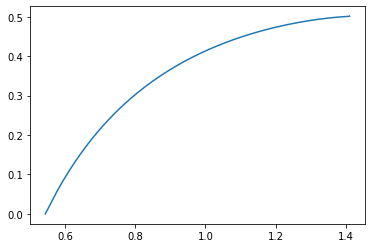

In [10]:
plt.plot(f.Fr, f.lam)

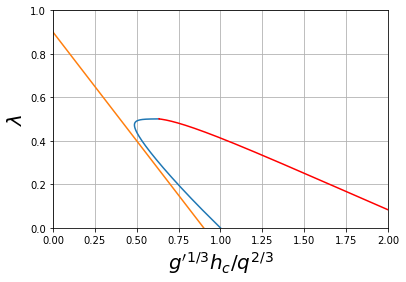

In [11]:
plt.plot(pow(gp*f.h2**3/(f.q1+f.q2)**2,2/3), f.lam)
plt.plot(pow(gp*H2**3/(f.q1+f.q2)**2,2/3), f.lam, 'r')

xFan = np.linspace(0,2,1000)
a = 0.1
b = 1
c0c2Fan = a + b*xFan
plt.plot(xFan, 1-c0c2Fan)

plt.gca().set(xlabel="$g'^{1/3}h_c/q^{2/3}$", ylabel="$\lambda$")
plt.axis([0,2,0,1])
plt.grid()
plt.show()

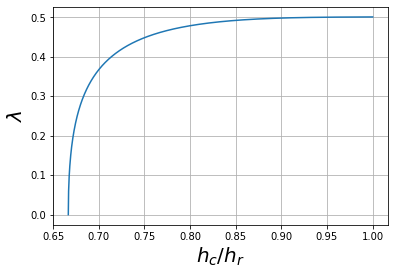

In [12]:
plt.plot(f.h2/H2, f.lam)

plt.gca().set(xlabel="$h_c/h_r$", ylabel="$\lambda$")
plt.grid()
plt.show()

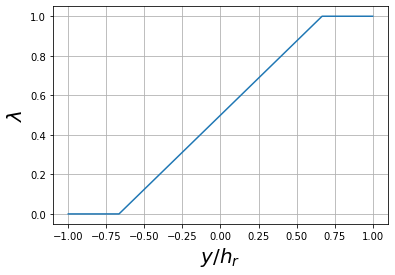

In [13]:
hr = 0.5
yFan = np.linspace(-hr,hr,1000)
hL = 2/3*hr
c0c2 = 0.5-0.5*yFan/hL
c0c2[yFan>hL] = 0
c0c2[yFan<-hL] = 1



plt.plot(yFan/hr, 1-c0c2)
plt.gca().set(xlabel="$y/h_r$", ylabel="$\lambda$")
plt.grid()
#plt.axis([0,1,0,1])

[Text(0.5, 0, "$g'^{1/3}h_r/q^{2/3}$"), Text(0, 0.5, '$1-\\lambda$')]

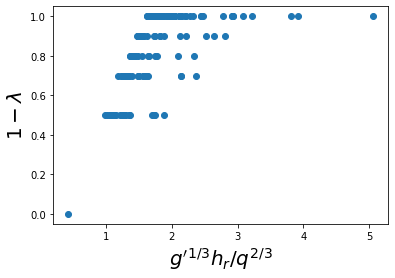

In [14]:
#plt.plot(pow(NL1204.rhofrac*9.81,1/3)*NL1204.am/pow(NL1204.q,2/3), 1-NL1204.lam, 'o')
plt.plot(pow(NL1204.rhofrac*9.81,1/3)*NL1204.hr/pow(NL1204.q,2/3), 1-NL1204.lam, 'o')
plt.gca().set(xlabel="$g'^{1/3}h_r/q^{2/3}$", ylabel="$1-\lambda$")

# Yu et al. (2004) data fig 14

In [15]:
xYuFan = -np.array([0.5567505720823799,0.5189931350114416,0.319908466819222,0.3336384439359268,0.319908466819222,
                    0.25469107551487413,0.2752860411899314,0.2855835240274598,0.26498855835240276,0.15858123569794036,
                    0.15858123569794036,-0.0027459954233410855,-0.0027459954233410855,0.15858123569794036,
                    0.0006864988558352714,-0.0027459954233410855,-0.0027459954233410855,-0.36659038901601826,
                    -0.4009153318077803,-0.43180778032036615,-0.40778032036613276,-0.5862700228832953,-0.5347826086956522,
                    -0.5725400457665903,-0.5999999999999999,0.5430205949656752,0.15858123569794036])

yYuFan = np.array([0.07142857142857162,0.12244897959183676,0.2081632653061225,0.22653061224489812,0.23877551020408183,
                   0.2489795918367348,0.28979591836734697,0.31224489795918386,0.3326530612244899,0.36530612244897975,
                   0.4142857142857145,0.4142857142857145,0.4469387755102042,0.6346938775510205,0.5918367346938777,
                   0.6346938775510205,0.6755102040816328,0.7816326530612246,0.8122448979591839,0.83265306122449,
                   0.8734693877551022,0.9265306122448982,0.9469387755102042,0.9571428571428573,0.9448979591836737,
                   0.10408163265306136,0.3938775510204082])

#For z0/H = 0.4
x04 = np.array([-0.17093750000000005, -0.15781250000000008, -0.14, 
              -0.016249999999999987, -0.021875000000000033, -0.019999999999999962, 
              -0.016249999999999987, -0.0012499999999999734, -0.0012499999999999734, 
              -0.0012499999999999734, 0.0025000000000000022, 0.007187500000000013, 
              0.04656250000000006, 0.06625000000000003, 0.08125000000000004, 
              0.06718750000000001, 0.150625, 0.19000000000000006, 0.20125000000000004, 
              0.22187500000000004])
y04 = np.array([0.07674418604651168, 0.11860465116279073, 0.14883720930232558, 0.3046511627906977, 
              0.3046511627906977, 0.32558139534883723, 0.3418604651162791, 0.41162790697674423, 
              0.430232558139535, 0.4744186046511628, 0.6511627906976745, 0.6813953488372093, 
              0.7906976744186047, 0.7906976744186047, 0.8302325581395349, 0.844186046511628, 
              0.9534883720930233, 0.9744186046511629, 0.9488372093023256, 0.9697674418604652])

#For z0/H = 0.2
x02 = np.array([-0.03125, -0.034999999999999976, -0.02562500000000001, -0.011562499999999976, 
                -0.0012499999999999734, -0.00031249999999999334, -0.00031249999999999334, 
                0.0025000000000000022, 0.0034374999999999822, 0.0015624999999999667, 0.005312499999999942])
y02 = np.array([0.2209302325581396, 0.23488372093023258, 0.25116279069767444, 0.2534883720930232, 
                0.3813953488372094, 0.40697674418604657, 0.45813953488372106, 0.5976744186046512, 
                0.6116279069767443, 0.6395348837209303, 0.6558139534883721])

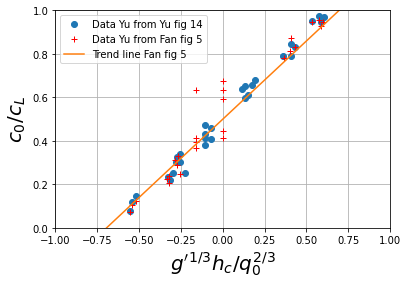

In [17]:
plt.plot(Yu.Gy, Yu.c0_f_c2,'o', label="Data Yu from Yu fig 14")
plt.plot(xYuFan,yYuFan,'+r', label="Data Yu from Fan fig 5")

G2yFan = np.linspace(-1,1,1000)
c0c2Fan = 0.5 + 0.72*G2yFan
plt.plot(G2yFan, c0c2Fan, label="Trend line Fan fig 5")

plt.axis([-1,1,0,1])
plt.gca().set(xlabel="$g'^{1/3}h_c/q_0^{2/3}$", ylabel="$c_0/c_L$")
plt.grid()
plt.legend()
plt.show()

# Datacheck Jirka fig 3

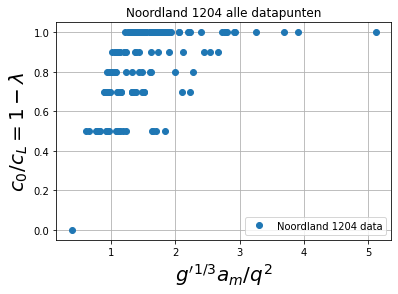

In [17]:
xNL = (9.81*NL1204.rhofrac)**(1/3) * NL1204.am / pow(NL1204.q,2/3)
yNL = 1-NL1204.lam

plt.plot(xNL, yNL, 'o', label="Noordland 1204 data")
plt.gca().set(xlabel="$g'^{1/3}a_m/q^2$", ylabel="$c_0/c_L = 1-\lambda$", title="Noordland 1204 alle datapunten")
plt.grid()
plt.legend()
plt.show()

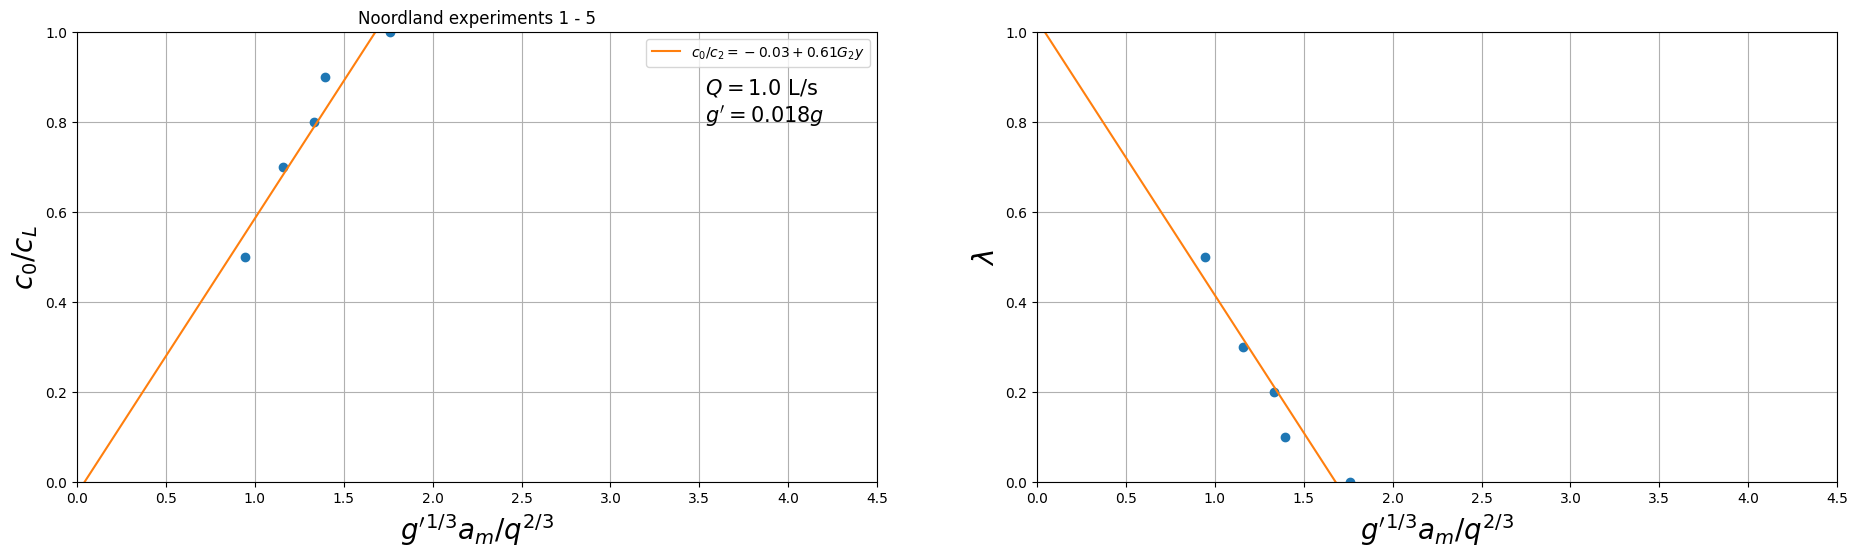

In [241]:
#sel = np.where(NL1204.D/NL1204.hr < 2/3)[0]
sel = np.arange(5)
#sel = np.arange(7,12)
#sel = np.arange(12,18)
#sel = np.arange(19,25)
#sel = np.arange(27,32)
#sel = np.arange(34,39)
#sel = np.arange(39,45)
#sel = np.arange(68,74)
#sel = np.arange(129,133)
NL1204sel = NL1204.iloc[sel]
xNL = (9.81*NL1204sel.rhofrac)**(1/3) * NL1204sel.am / pow(NL1204sel.q,2/3)
yNL = 1-NL1204sel.lam

G2y = np.linspace(0,5,1000)
p = np.polyfit(xNL,yNL,1)
c0c2fit = p[1] + p[0]*G2y

####PLOT
figprops = dict(figsize=(16, 9), dpi=100)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel="$g'^{1/3}a_m/q^{2/3}$", ylabel="$c_0/c_L$", title="Noordland experiments {0} - {1}".format(NL1204sel.experiment.iloc[0],NL1204sel.experiment.iloc[-1]))
ax.axis([0,4.5,0,1])
ax.grid()

ax.plot(xNL, yNL, 'o', label="")
#ax.plot((9.81*NL1204sel.rhofrac)**(1/3) * NL1204sel.hr / pow(NL1204sel.q,2/3), 1-NL1204sel.lam, 'or')
ax.plot(G2y, c0c2fit, label="$c_0/c_2={0:.2f}+{1:.2f}G_2y$".format(p[1],p[0]))
ax.legend()
ax.text(3.5,0.8," $Q={0}$ L/s \n $g'={1}g$".format(NL1204sel.Q_1000.iloc[0],NL1204sel.rhofrac.iloc[0]), size=15)

bx = plt.axes([0.6, 0, .5, .5])
bx.set(xlabel="$g'^{1/3}a_m/q^{2/3}$", ylabel="$\lambda$")
bx.axis([0,4.5,0,1])
bx.grid()

bx.plot(xNL, NL1204sel.lam, 'o', label="")
bx.plot(G2y, 1-c0c2fit)

plt.show()

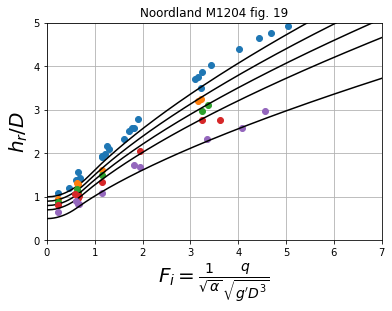

In [19]:
ref3 = np.arange(27)
#ref3 = np.where(NL1204.iloc[ref3].D<2/3*NL1204.iloc[ref3].hr)[0]
ref6 = np.arange(27,47)
ref = np.concatenate([np.arange(47), np.arange(77,99)])
NL1204ref = NL1204.iloc[ref]
NL1204ref3 = NL1204.iloc[ref3]
NL1204ref6 = NL1204.iloc[ref6]

alpha = 1.25

for n in np.array([0, 0.1, 0.2, 0.3, 0.5]):
    hrD = np.linspace(1-n,5,1001)
    Fi = np.zeros(len(hrD))
    NL1204toplot = NL1204ref[NL1204ref.lam==n]
    plt.plot(NL1204toplot.q/NL1204toplot.D/np.sqrt(NL1204toplot.rhofrac*9.81*NL1204toplot.D),
             NL1204toplot.hr/NL1204toplot.D, 'o')

    Fi[1/hrD <= 2/3/(1-n)] = 1/np.sqrt(alpha) * 1/(1-n)*2/3*hrD[1/hrD <= 2/3/(1-n)]*np.sqrt(2/3*hrD[1/hrD <= 2/3/(1-n)])
    Fi[1/hrD > 2/3/(1-n)] = 1/np.sqrt(alpha) * np.sqrt(2*(hrD[1/hrD > 2/3/(1-n)]-(1-n)))
    plt.plot(Fi, hrD, 'k')
    
plt.gca().set(xlabel=r"$F_i= \frac{1}{\sqrt{\alpha}}\frac{q}{\sqrt{g'D^3}}$", ylabel="$h_r/D$", title="Noordland M1204 fig. 19")
plt.axis([0,7,0,5])
plt.grid()

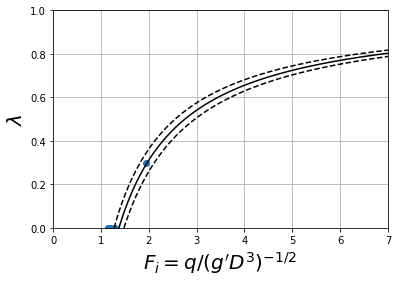

In [20]:
ref3 = np.arange(27)
ref6 = np.arange(27,47)
NL1204ref3 = NL1204.iloc[ref3]
NL1204ref6 = NL1204.iloc[ref6]

ref = np.concatenate([np.arange(47), np.arange(77,99)])
#ref = np.arange(177)
NL1204ref = NL1204.iloc[ref]

n = np.linspace(0,0.99,1001)
Fi = np.zeros(len(n))
Fimin = np.zeros(len(n))
Fiplus = np.zeros(len(n))

hrD = 2
dhrD = 0.1
sel = np.where((NL1204ref.hr/NL1204ref.D>hrD-dhrD) & (NL1204ref.hr/NL1204ref.D<hrD+dhrD))[0]
NL1204toplot = NL1204ref.iloc[sel]
Fi[1/hrD <= 2/3/(1-n)] = 1/(1-n[1/hrD <= 2/3/(1-n)])*2/3*hrD*np.sqrt(2/3*hrD)
Fi[1/hrD > 2/3/(1-n)] = np.sqrt(2*(hrD-(1-n[1/hrD > 2/3/(1-n)])))
Fimin[1/(hrD-dhrD) <= 2/3/(1-n)] = 1/(1-n[1/(hrD-dhrD) <= 2/3/(1-n)])*2/3*(hrD-dhrD)*np.sqrt(2/3*(hrD-dhrD))
Fimin[1/(hrD-dhrD) > 2/3/(1-n)] = np.sqrt(2*((hrD-dhrD)-(1-n[1/(hrD-dhrD) > 2/3/(1-n)])))
Fiplus[1/(hrD+dhrD) <= 2/3/(1-n)] = 1/(1-n[1/(hrD+dhrD) <= 2/3/(1-n)])*2/3*(hrD+dhrD)*np.sqrt(2/3*(hrD+dhrD))
Fiplus[1/(hrD+dhrD) > 2/3/(1-n)] = np.sqrt(2*((hrD+dhrD)-(1-n[1/(hrD+dhrD) > 2/3/(1-n)])))

plt.plot(NL1204toplot.q/NL1204toplot.D/np.sqrt(NL1204toplot.rhofrac*9.81*NL1204toplot.D),
         NL1204toplot.lam, 'o')

alpha = 1.25
plt.plot(1/np.sqrt(alpha)*Fimin, n, '--k')
plt.plot(1/np.sqrt(alpha)*Fi, n, 'k')
plt.plot(1/np.sqrt(alpha)*Fiplus, n, '--k')

plt.gca().set(xlabel="$F_i=q/(g'D^3)^{-1/2}$", ylabel="$\lambda$")
plt.axis([0,7,0,1])
plt.grid()

<ipython-input-21-23b5015be5d0>:18: RuntimeWarning: invalid value encountered in sqrt
  Fimin[1/(hrD-dhrD) > 2/3/(1-n)] = np.sqrt(2*((hrD-dhrD)-(1-n[1/(hrD-dhrD) > 2/3/(1-n)])))


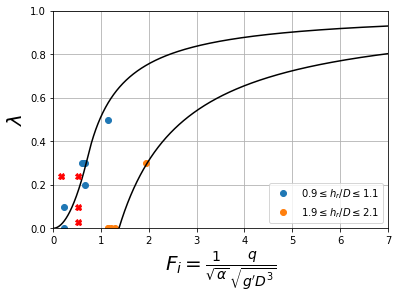

In [21]:
ref = np.concatenate([np.arange(47), np.arange(77,99)])
#ref = np.arange(177)
NL1204ref = NL1204.iloc[ref]

n = np.linspace(0,0.99,1001)
Fi = np.zeros(len(n))
Fimin = np.zeros(len(n))
Fiplus = np.zeros(len(n))

alpha = 1.25
dhrD = 0.1
for hrD in np.array([1, 2]):
    sel = np.where((NL1204ref.hr/NL1204ref.D>hrD-dhrD) & (NL1204ref.hr/NL1204ref.D<hrD+dhrD))[0]
    NL1204toplot = NL1204ref.iloc[sel]
    Fi[1/hrD <= 2/3/(1-n)] = 1/np.sqrt(alpha)*1/(1-n[1/hrD <= 2/3/(1-n)])*2/3*hrD*np.sqrt(2/3*hrD)
    Fi[1/hrD > 2/3/(1-n)] = 1/np.sqrt(alpha)*np.sqrt(2*(hrD-(1-n[1/hrD > 2/3/(1-n)])))
    Fimin[1/(hrD-dhrD) <= 2/3/(1-n)] = 1/(1-n[1/(hrD-dhrD) <= 2/3/(1-n)])*2/3*(hrD-dhrD)*np.sqrt(2/3*(hrD-dhrD))
    Fimin[1/(hrD-dhrD) > 2/3/(1-n)] = np.sqrt(2*((hrD-dhrD)-(1-n[1/(hrD-dhrD) > 2/3/(1-n)])))
    Fiplus[1/(hrD+dhrD) <= 2/3/(1-n)] = 1/(1-n[1/(hrD+dhrD) <= 2/3/(1-n)])*2/3*(hrD+dhrD)*np.sqrt(2/3*(hrD+dhrD))
    Fiplus[1/(hrD+dhrD) > 2/3/(1-n)] = np.sqrt(2*((hrD+dhrD)-(1-n[1/(hrD+dhrD) > 2/3/(1-n)])))

    plt.plot(NL1204toplot.q/NL1204toplot.D/np.sqrt(NL1204toplot.rhofrac*9.81*NL1204toplot.D),
             NL1204toplot.lam, 'o', label=r"${0} \leq h_r/D \leq {1}$".format(hrD-dhrD, hrD+dhrD))

    #plt.plot(1/np.sqrt(alpha)*Fimin, n, '--k')
    plt.plot(Fi, n, 'k')
    #plt.plot(1/np.sqrt(alpha)*Fiplus, n, '--k')

### IJmuiden
plt.plot(IJ.q/IJ.D/np.sqrt(IJ.rhofrac*9.81*IJ.D),
         IJ.lam, 'Xr')
    
plt.gca().set(xlabel=r"$F_i= \frac{1}{\sqrt{\alpha}}\frac{q}{\sqrt{g'D^3}}$", ylabel="$\lambda$")
plt.axis([0,7,0,1])
plt.grid()
plt.legend()

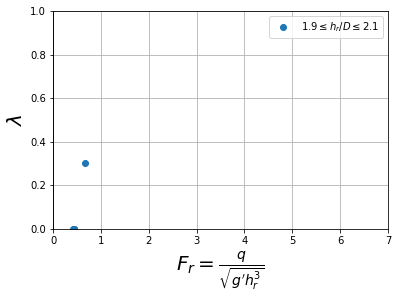

In [22]:
ref = np.concatenate([np.arange(47), np.arange(77,99)])
#ref = np.arange(177)
NL1204ref = NL1204.iloc[ref]

n = np.linspace(0,0.99,1001)
Fi = np.zeros(len(n))
Fimin = np.zeros(len(n))
Fiplus = np.zeros(len(n))

alpha = 1.25
dhrD = 0.1
for hrD in np.array([2]):
    sel = np.where((NL1204ref.hr/NL1204ref.D>hrD-dhrD) & (NL1204ref.hr/NL1204ref.D<hrD+dhrD))[0]
    NL1204toplot = NL1204ref.iloc[sel]
    #Fi[1/hrD <= 2/3/(1-n)] = 1/np.sqrt(alpha)*1/(1-n[1/hrD <= 2/3/(1-n)])*2/3*hrD*np.sqrt(2/3*hrD)
    #Fi[1/hrD > 2/3/(1-n)] = 1/np.sqrt(alpha)*np.sqrt(2*(hrD-(1-n[1/hrD > 2/3/(1-n)])))
    #Fimin[1/(hrD-dhrD) <= 2/3/(1-n)] = 1/(1-n[1/(hrD-dhrD) <= 2/3/(1-n)])*2/3*(hrD-dhrD)*np.sqrt(2/3*(hrD-dhrD))
    #Fimin[1/(hrD-dhrD) > 2/3/(1-n)] = np.sqrt(2*((hrD-dhrD)-(1-n[1/(hrD-dhrD) > 2/3/(1-n)])))
    #Fiplus[1/(hrD+dhrD) <= 2/3/(1-n)] = 1/(1-n[1/(hrD+dhrD) <= 2/3/(1-n)])*2/3*(hrD+dhrD)*np.sqrt(2/3*(hrD+dhrD))
    #Fiplus[1/(hrD+dhrD) > 2/3/(1-n)] = np.sqrt(2*((hrD+dhrD)-(1-n[1/(hrD+dhrD) > 2/3/(1-n)])))

    plt.plot(NL1204toplot.q/NL1204toplot.hr/np.sqrt(NL1204toplot.rhofrac*9.81*NL1204toplot.hr),
             NL1204toplot.lam, 'o', label=r"${0} \leq h_r/D \leq {1}$".format(hrD-dhrD, hrD+dhrD))

    #plt.plot(1/np.sqrt(alpha)*Fimin, n, '--k')
    plt.plot(Fi, n, 'k')
    #plt.plot(1/np.sqrt(alpha)*Fiplus, n, '--k')

plt.gca().set(xlabel=r"$F_r= \frac{q}{\sqrt{g'h_r^3}}$", ylabel="$\lambda$")
plt.axis([0,7,0,1])
plt.grid()
plt.legend()

# Murota & Michioku

In [238]:
eta_c = 0;
eta = np.linspace(eta_c,1,1000) #y/h2
m = 0.3 #h2/h1
alphac = 1.4
alpha0 = 1.0
beta = 3.0
alpha1 = np.sqrt((alphac-alpha0)*np.exp(-beta*(eta-eta_c)/(1-eta_c))+alpha0)
alpha2 = np.sqrt((alphac-alpha0)*np.exp(-beta*(eta-eta_c)/(1-eta_c))+alpha0)
alpha1 = 1.4
alpha2 = 1.4

r = np.sqrt(rho_2/rho_1 * (alpha2/alpha1)**2 * ( (1+m-m*eta)**3 *m*(3*eta-2-eta**3/alpha2**2) )/\
            ( (m*eta)**3*(1+3*m-3*m*eta-(1+m-m*eta)**3/alpha1**2) ))
Fr = ( np.sqrt(1/(alpha1**2*m**2) *(1+m-m*eta)**3 *(3*eta-2-eta**3/alpha2**2)) + \
       np.sqrt(rho_1/rho_2*eta**3/alpha2**2*(1+3*m-3*m*eta)-(1+m-m*eta)**3/alpha1**2) )/\
      ( np.sqrt(1+m-(1+m-m*eta)**3/alpha1**2 -m*eta**3/alpha2**2 ) )
Fc = np.sqrt( eta_c**3/alpha2**2 * ( 1+3*m-3*m*eta_c - (1+m-m*eta_c)**3/alpha2**2 )/\
             ( 1+m-m*eta_c**3/alpha2**2 - (1+m-m*eta_c)**3/alpha2**2 ) )
lam = r/(r+1)*(m+1)

<ipython-input-238-6c522264a51c>:12: RuntimeWarning: divide by zero encountered in true_divide
  r = np.sqrt(rho_2/rho_1 * (alpha2/alpha1)**2 * ( (1+m-m*eta)**3 *m*(3*eta-2-eta**3/alpha2**2) )/\
<ipython-input-238-6c522264a51c>:12: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt(rho_2/rho_1 * (alpha2/alpha1)**2 * ( (1+m-m*eta)**3 *m*(3*eta-2-eta**3/alpha2**2) )/\
<ipython-input-238-6c522264a51c>:14: RuntimeWarning: invalid value encountered in sqrt
  Fr = ( np.sqrt(1/(alpha1**2*m**2) *(1+m-m*eta)**3 *(3*eta-2-eta**3/alpha2**2)) + \
<ipython-input-238-6c522264a51c>:15: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(rho_1/rho_2*eta**3/alpha2**2*(1+3*m-3*m*eta)-(1+m-m*eta)**3/alpha1**2) )/\


In [240]:
Fr

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [208]:
alpha2s = 1.4
alpha2s/pow(np.sqrt(alpha2s**2-alpha2s**3)-alpha2s,1/3) + pow(np.sqrt(alpha2s**2-alpha2s**3)-alpha2s,1/3) 

<ipython-input-208-3b19b0cdb0c9>:2: RuntimeWarning: invalid value encountered in sqrt
  alpha2s/pow(np.sqrt(alpha2s**2-alpha2s**3)-alpha2s,1/3) + pow(np.sqrt(alpha2s**2-alpha2s**3)-alpha2s,1/3)


nan

In [205]:
np.sqrt(alpha2**4-alpha2**6)-alpha2**2

-5.0125628933800695e-05

In [164]:
print(rho_2/rho_1 * (alpha2/alpha1)**2 * ( (1+m-m*eta)**3 *m*(3*eta-2-eta**3/alpha2**2) )/\
            ( (m*eta)**3*(1+3*m-3*m*eta-(1+m-m*eta)**3/alpha1**2) ))
print(1/(alpha1**2*m**2) *(1+m-m*eta)**3 *(3*eta-2-eta**3/alpha2**2))
print(rho_1/rho_2*eta**3/alpha2**2*(1+3*m-3*m*eta)-(1+m-m*eta)**3/alpha1**2)
print(1+m-(1+m-m*eta)**3/alpha1**2 -m*eta**3/alpha2**2 )

[-7.25950439e+01 -7.31102762e+01 -7.36312509e+01 -7.41580496e+01
 -7.46907555e+01 -7.52294529e+01 -7.57742279e+01 -7.63251679e+01
 -7.68823621e+01 -7.74459010e+01 -7.80158768e+01 -7.85923835e+01
 -7.91755167e+01 -7.97653735e+01 -8.03620530e+01 -8.09656560e+01
 -8.15762853e+01 -8.21940452e+01 -8.28190423e+01 -8.34513848e+01
 -8.40911832e+01 -8.47385498e+01 -8.53935992e+01 -8.60564478e+01
 -8.67272146e+01 -8.74060204e+01 -8.80929885e+01 -8.87882444e+01
 -8.94919162e+01 -9.02041341e+01 -9.09250310e+01 -9.16547422e+01
 -9.23934056e+01 -9.31411619e+01 -9.38981544e+01 -9.46645291e+01
 -9.54404348e+01 -9.62260234e+01 -9.70214497e+01 -9.78268712e+01
 -9.86424491e+01 -9.94683472e+01 -1.00304733e+02 -1.01151777e+02
 -1.02009653e+02 -1.02878538e+02 -1.03758614e+02 -1.04650066e+02
 -1.05553081e+02 -1.06467852e+02 -1.07394576e+02 -1.08333451e+02
 -1.09284683e+02 -1.10248480e+02 -1.11225055e+02 -1.12214624e+02
 -1.13217410e+02 -1.14233638e+02 -1.15263540e+02 -1.16307352e+02
 -1.17365315e+02 -1.18437